<a href="https://colab.research.google.com/github/ProjectXMG999/ProjectXMG999-NLP-Text-generation-classification/blob/main/Generating_songs_from_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# generating songs using RNNs (kaggle dataset)

- 10k lines of lyrics( wont using full dataset couse of processing time)
- predicting new wrod from a sequence
- make the output a one-hot encoded label over entire corpus of desired text outputs
- Using np.random.choice with the probabilities for more variance in predicted outputs
- using only top-k most common words
- tuning model
- https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset

In [1]:
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional


import string
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv


--2023-03-09 20:10:57--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 209.85.146.113, 209.85.146.139, 209.85.146.102, ...
Connecting to drive.google.com (drive.google.com)|209.85.146.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1men9hubr8e9svj3bpfg86ds4ri0744n/1678392600000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=bd35b210-dee4-4439-a908-3385a8fb5c81 [following]
--2023-03-09 20:11:00--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1men9hubr8e9svj3bpfg86ds4ri0744n/1678392600000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=bd35b210-dee4-4439-a908-3385a8fb5c81
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 64.233.191.132, 2607:f8b0:4001:c0c::84
Connecting to doc-04

In [2]:
# Preprocessing

def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus


def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


<ipython-input-2-a08e8deff054>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-2-a08e8deff054>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


In [3]:
# creating sequences and labels

sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [4]:
# training tex generation model

#  cutting of after 100 epochs ( no time for that)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 30s 14ms/step - loss: 5.9842 - accuracy: 0.0462
Epoch 2/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.7069 - accuracy: 0.0501
Epoch 3/100
1480/1480 [==============================] - 10s 7ms/step - loss: 5.5156 - accuracy: 0.0635
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.3027 - accuracy: 0.0968
Epoch 5/100
1480/1480 [==============================] - 11s 7ms/step - loss: 5.1410 - accuracy: 0.1161
Epoch 6/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.0007 - accuracy: 0.1301
Epoch 7/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.8726 - accuracy: 0.1404
Epoch 8/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.7569 - accuracy: 0.1511
Epoch 9/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.6443 - accuracy: 0.1623
Epoch 10/100
1480/1480 [==============================] - 11s 8

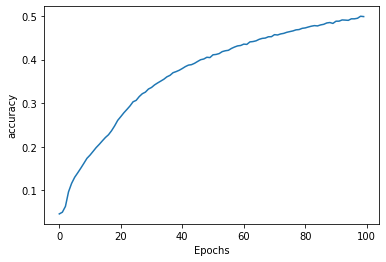

In [5]:
# Visualization


import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [6]:
# generating time


seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 36ms/step
im feeling chills me to me tonight and now youre so hard when you please think of me and bobby and bobbys brother the bone day tune hell wed good more to joy door intrusion mess girls mama love tramp kids throat images chasing flash bother share share world beg choice share share share share explain complain knees beams misery crowd trooper trooper lousy lesson outward world given john mm john resist chasing feather feather movie movie wonderful great gritty chasing bird wall bang head like paint close close mighty above couldnt roxy thats me best shut couldnt tell me i have to


In [7]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 [==============================] - 0s 24ms/step
7


In [8]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 23ms/step
im feeling chills it all youre at my sense dont i have come and cry now youre headin down tonight close your shoes from short me like a blues through laugh jeanie than breaking place around where spin by fall shut harm me out me things think that i bring on you twice stops you shines you better life use man is a fool into deep over faces baby break ya things conceal chat choice no goin choice choice choice choice choice choice choice harm beg thrill rather this things beg harm remember shine talking call nothings bittersweet go losin write of certain
